In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Dropout, MaxPooling1D, Flatten, LSTM
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
import pandas as pd

Using TensorFlow backend.
/home/ccg/.virtualenvs/torch/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ccg/.virtualenvs/torch/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ccg/.virtualenvs/torch/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ccg/.virtualenvs/torch/lib/pytho

In [51]:
filename="DB_modified.csv"
dataset = pd.read_csv(filename, header=None)
dataset =np.array(dataset)[1:-1]

dataset=np.asfarray(dataset,float)
dataset.shape

(2159, 8)

In [52]:
X=dataset[:,:7]
print(X)
# X=(X-np.mean(X))/np.std(X)

# X=dataset[:,2]
X[:,1]=(X[:,1]-np.mean(X[:,1]))/np.std(X[:,1])
X[:,2]=(X[:,2]-np.mean(X[:,2]))/np.std(X[:,2])
X[:,3]=(X[:,3]-np.mean(X[:,3]))/np.std(X[:,3])

# X[:,1]=X[:,1]/np.max(X[:,1])
# y=dataset[:,6]
# Vthin=dataset[:,-2]
# np.concatenate((X, np.expand_dims(Vthin, 1)), 1)
# print(X)
# print(y.shape)
# X=np.expand_dims(X, 1)
X

[[ 0.00000e+00  2.00000e+16  1.50000e-02 ...  2.34535e+01  7.40640e+01
  -4.57000e-01]
 [ 0.00000e+00  2.00000e+16  1.50000e-02 ...  3.89934e+01  8.22240e+01
  -7.16000e-01]
 [ 0.00000e+00  2.00000e+16  1.50000e-02 ...  5.88290e+01  9.01560e+01
  -9.77000e-01]
 ...
 [ 1.00000e+00  1.00000e+19  2.90000e-02 ...  4.04002e+02  1.01472e+02
  -5.41000e+00]
 [ 1.00000e+00  1.00000e+19  2.90000e-02 ...  4.44592e+02  1.06572e+02
  -5.93500e+00]
 [ 1.00000e+00  1.00000e+19  2.90000e-02 ...  4.83730e+02  1.11408e+02
  -6.46400e+00]]


array([[ 0.00000000e+00, -6.99371203e-01, -1.52728978e+00, ...,
         2.34535000e+01,  7.40640000e+01, -4.57000000e-01],
       [ 0.00000000e+00, -6.99371203e-01, -1.52728978e+00, ...,
         3.89934000e+01,  8.22240000e+01, -7.16000000e-01],
       [ 0.00000000e+00, -6.99371203e-01, -1.52728978e+00, ...,
         5.88290000e+01,  9.01560000e+01, -9.77000000e-01],
       ...,
       [ 1.00000000e+00,  2.47843603e+00,  1.52870524e+00, ...,
         4.04002000e+02,  1.01472000e+02, -5.41000000e+00],
       [ 1.00000000e+00,  2.47843603e+00,  1.52870524e+00, ...,
         4.44592000e+02,  1.06572000e+02, -5.93500000e+00],
       [ 1.00000000e+00,  2.47843603e+00,  1.52870524e+00, ...,
         4.83730000e+02,  1.11408000e+02, -6.46400000e+00]])

In [23]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42, shuffle=True)
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, test_size=0.150, random_state=42, shuffle=True)
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)
print("x_cv:", x_cv.shape)
print("y_cv:", y_cv.shape)

NameError: name 'y' is not defined

In [ ]:
x_traindim =np.expand_dims(x_train, 1)
y_traindim =np.expand_dims(y_train, 1)
x_cvdim =np.expand_dims(x_cv, 1)
y_cvdim =np.expand_dims(y_cv, 1)
x_testdim =np.expand_dims(x_test, 1)
y_testdim =np.expand_dims(y_test, 1)
print("x_traindim:", x_traindim.shape)
print("y_traindim:", y_traindim.shape)
print("x_testdim:", x_testdim.shape)
print("y_testdim:", y_testdim.shape)
print("x_cvdim:", x_cvdim.shape)
print("y_cvdim:", y_cvdim.shape)

In [53]:
import keras
# print(x_traindim[0].shape)
from keras.layers import LSTM, Dense,Input, Conv2D, Flatten

In [54]:
from numpy import zeros
from numpy import ones
from numpy import hstack
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot

In [65]:
def define_discriminator(n_inputs=7):
    model = Sequential()
    model.add(Dense(64, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [66]:
def define_generator(latent_dim, n_outputs=7):
    model = Sequential()
    model.add(Dense(64, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(n_outputs, activation='linear'))
    return model

In [67]:
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [68]:
def generate_real_samples(n):
    X_return = X[np.random.randint(0, X.shape[0], size=n)]
    # generate inputs in [-0.5, 0.5]
#     X1 = rand(n) - 0.5
#     # generate outputs X^2
#     X2 = X1 * X1
#     # stack arrays
#     X1 = X1.reshape(n, 1)
#     X2 = X2.reshape(n, 1)
#     X = hstack((X1, X2))
#     # generate class labels
    y = ones((n, 1))
    return X_return, y


In [69]:
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

In [70]:
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((n, 1))
    return X, y

In [71]:
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
    # prepare real samples
    x_real, y_real = generate_real_samples(n)
    # evaluate discriminator on real examples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    # evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print(epoch, acc_real, acc_fake)
    # scatter plot real and fake data points
    pyplot.scatter(x_real[:, 3], x_real[:, 6], color='red')
    pyplot.scatter(x_fake[:, 3], x_fake[:,6], color='blue')
    pyplot.show()

In [74]:
def train(g_model, d_model, gan_model, latent_dim, n_epochs=100000, n_batch=128, n_eval=1000):
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare real samples
        x_real, y_real = generate_real_samples(half_batch)
       
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
#         print(x_gan.shape, y_gan.shape)
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)
        # evaluate the model every n_eval epochs
        if (i+1) % n_eval == 0:
            summarize_performance(i, g_model, d_model, latent_dim)

999 0.77 1.0


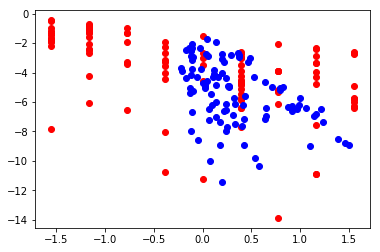

1999 0.68 0.67


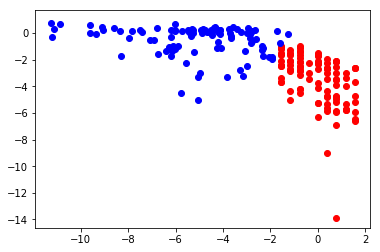

2999 0.67 0.91


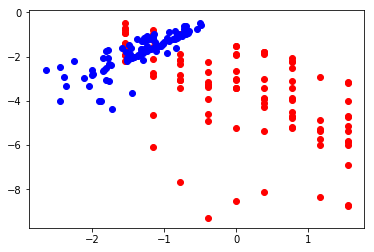

3999 0.4 1.0


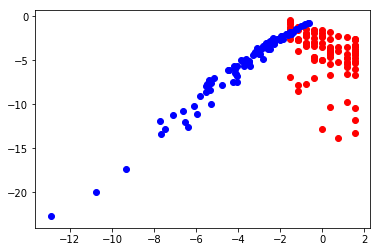

4999 0.79 0.99


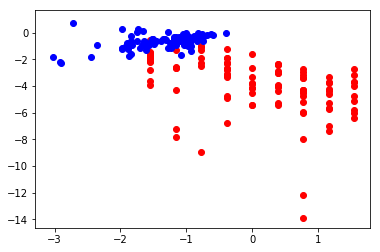

5999 0.53 0.86


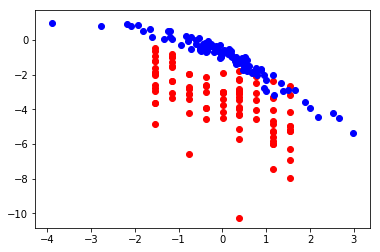

6999 1.0 1.0


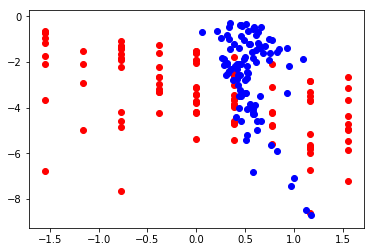

7999 0.87 1.0


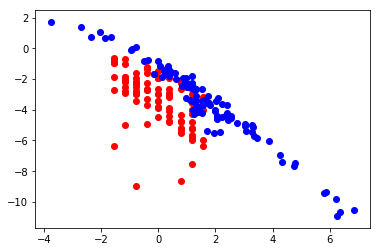

8999 0.65 0.97


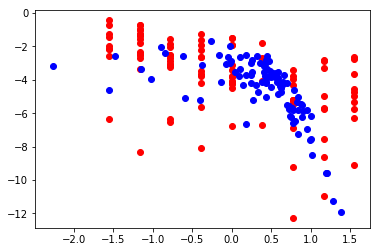

9999 0.51 0.57


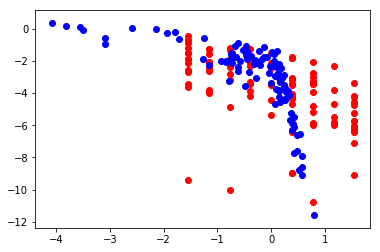

10999 0.82 0.93


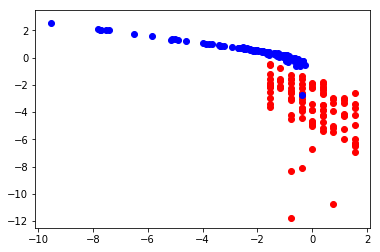

11999 0.11 0.6


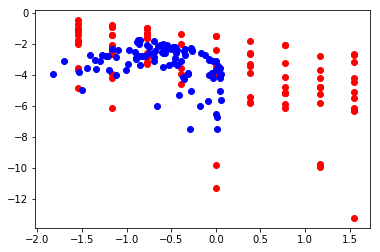

12999 0.81 0.98


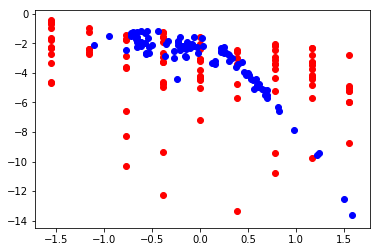

13999 0.89 0.85


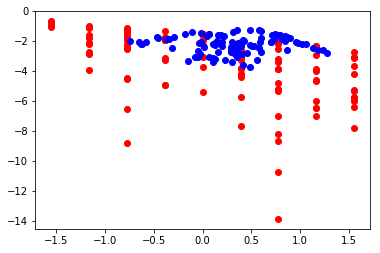

14999 0.68 0.71


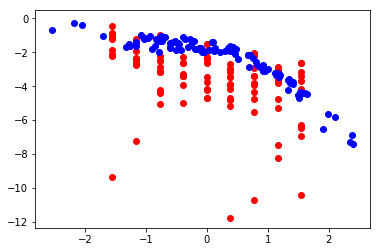

15999 0.73 0.94


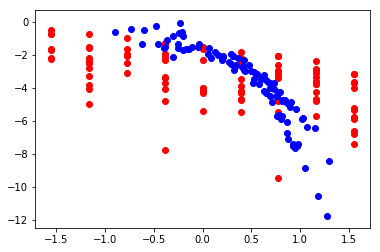

16999 0.6 0.89


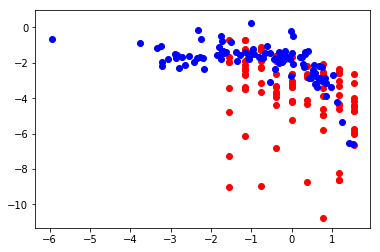

17999 0.51 0.93


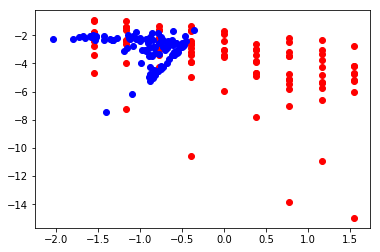

18999 0.42 0.77


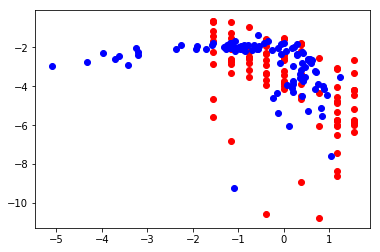

19999 0.54 0.91


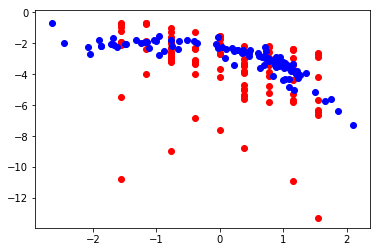

20999 0.86 1.0


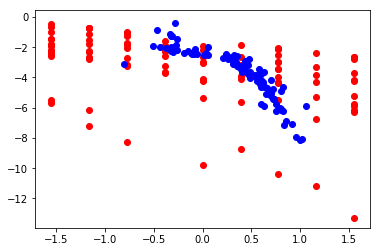

21999 0.91 0.97


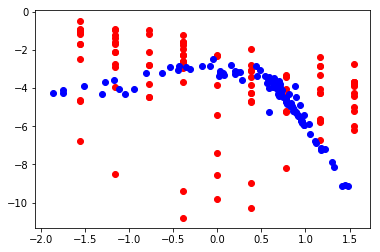

22999 0.51 0.94


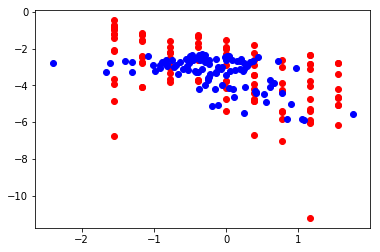

23999 0.31 0.8


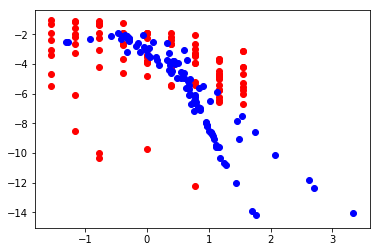

24999 0.7 0.99


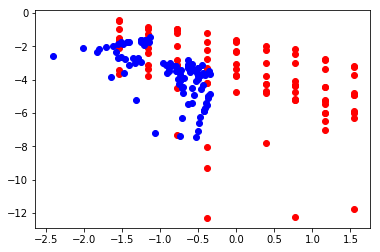

25999 0.75 0.71


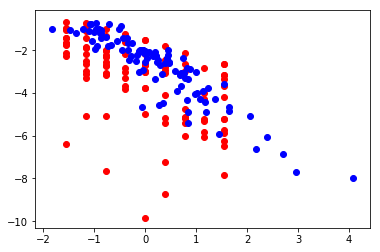

26999 0.63 0.9


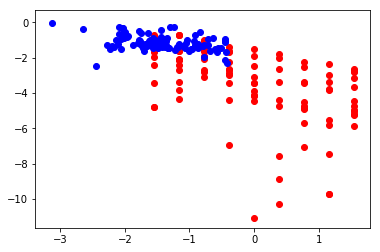

27999 0.71 0.97


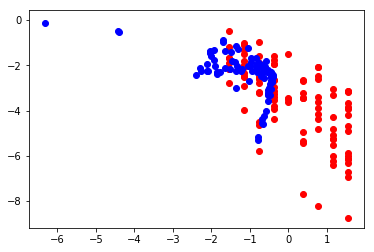

28999 0.73 0.97


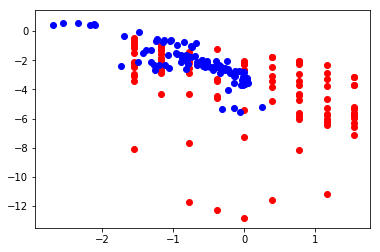

29999 0.83 0.92


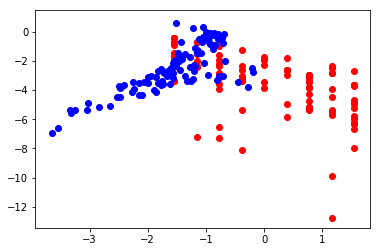

30999 0.75 0.88


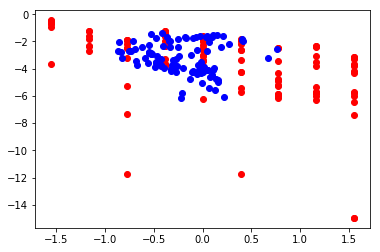

31999 0.88 0.91


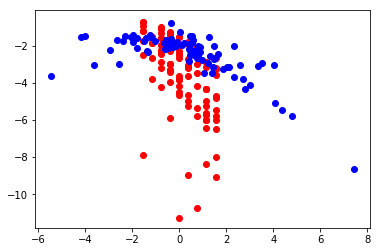

32999 0.69 0.77


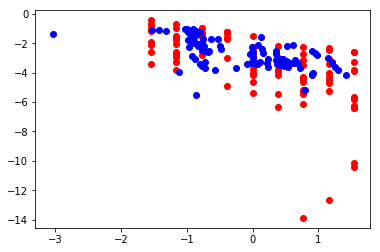

33999 0.66 0.38


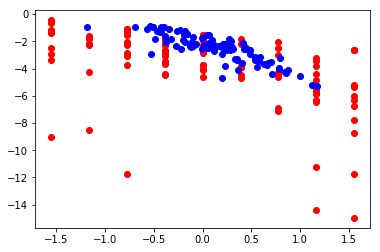

34999 0.67 0.57


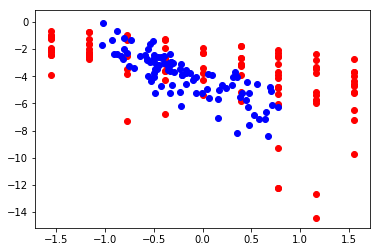

35999 0.36 0.79


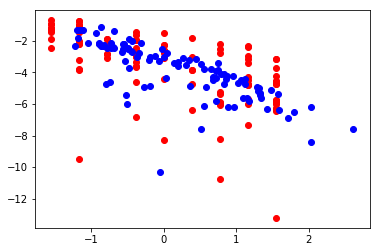

36999 0.95 1.0


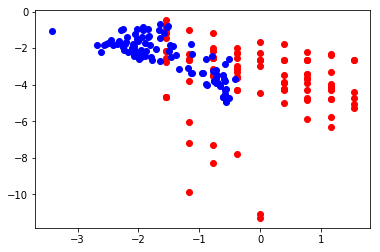

37999 0.56 0.05


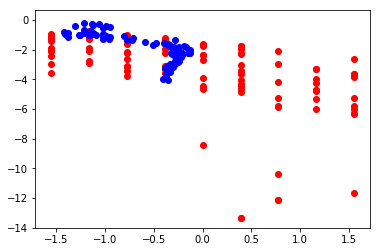

38999 0.44 0.81


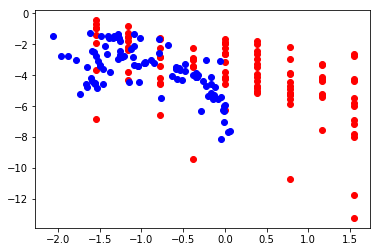

39999 0.34 0.86


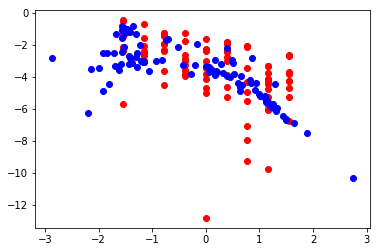

40999 0.83 0.91


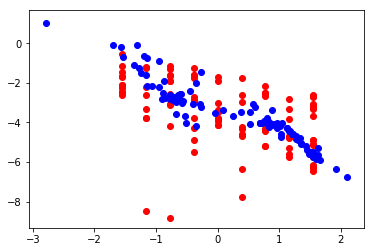

41999 0.59 0.25


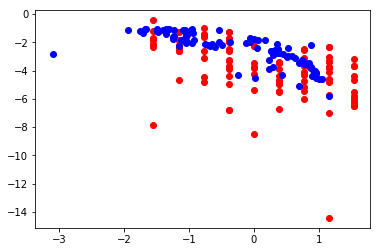

42999 0.51 0.66


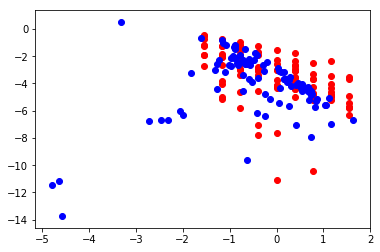

43999 0.41 0.7


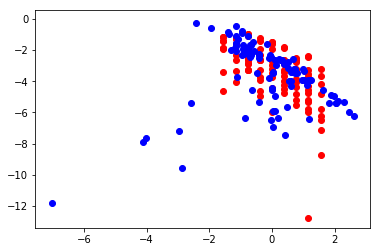

44999 0.15 0.89


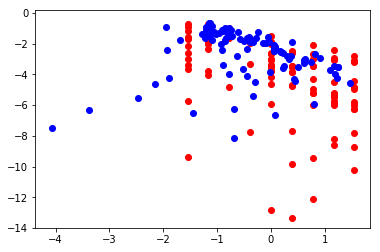

45999 0.02 1.0


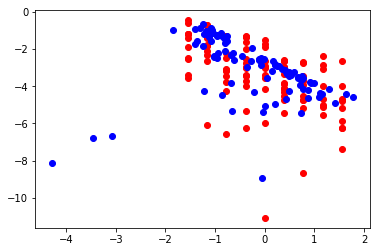

46999 0.91 0.07


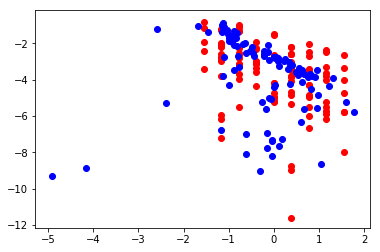

47999 1.0 0.11


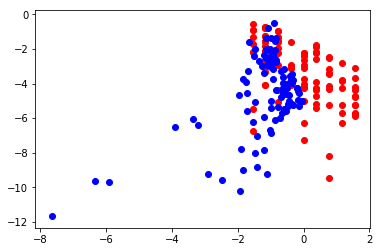

48999 0.0 1.0


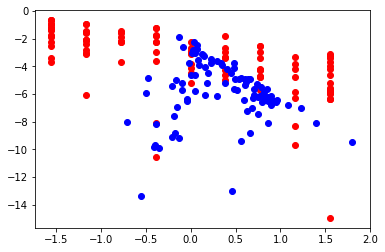

49999 0.0 1.0


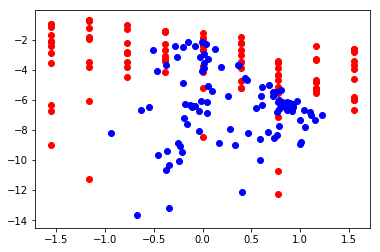

50999 0.0 1.0


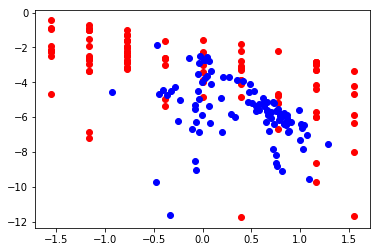

51999 0.0 1.0


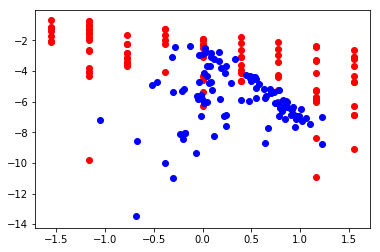

52999 0.0 1.0


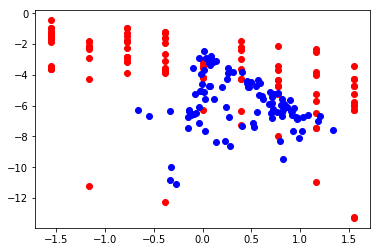

53999 0.0 1.0


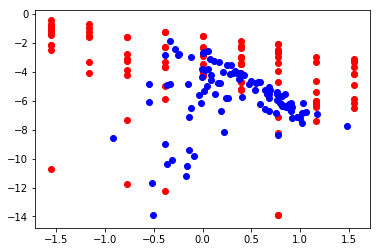

54999 0.0 1.0


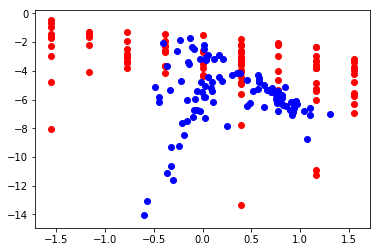

55999 0.0 1.0


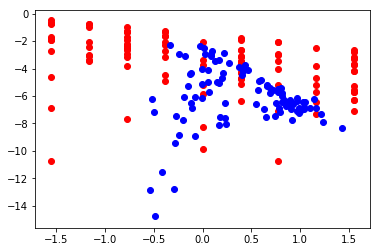

56999 0.0 1.0


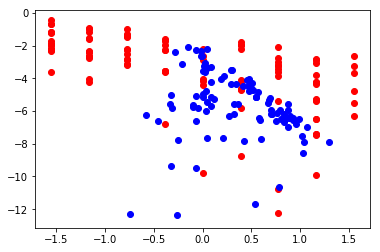

57999 0.0 1.0


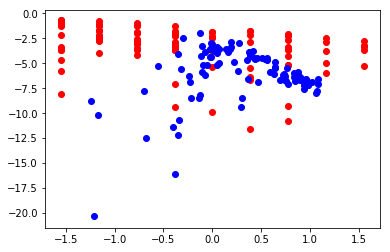

58999 0.0 1.0


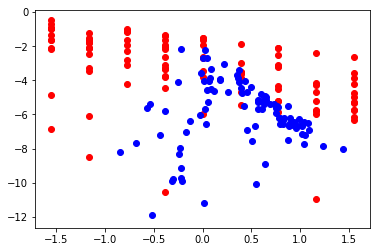

59999 0.0 1.0


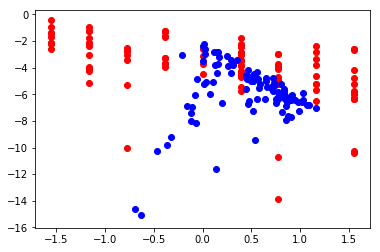

60999 0.0 1.0


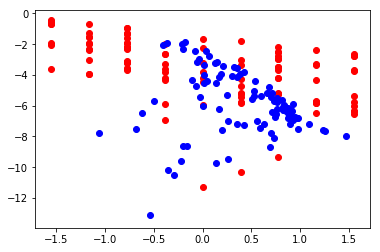

61999 0.0 1.0


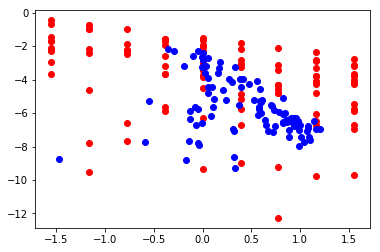

62999 0.0 1.0


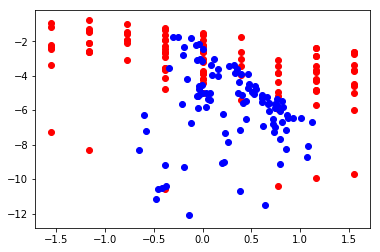

63999 0.0 1.0


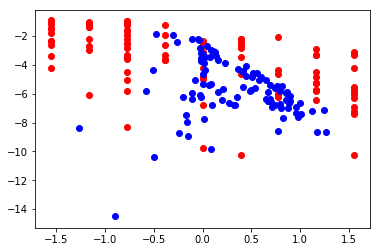

64999 0.0 1.0


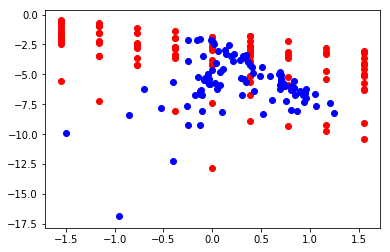

65999 0.0 1.0


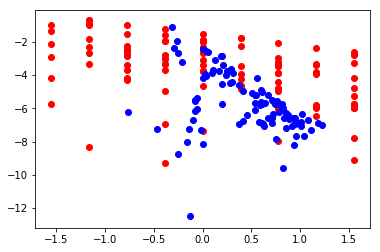

In [ ]:
latent_dim = 10
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)

In [18]:
x_real, y_real = generate_real_samples(2)
x_fake, y_fake = generate_fake_samples(generator, latent_dim, 2)

In [19]:
print(x_real, y_real)
print(x_fake, y_fake)

[[ 0.000000e+00  4.000000e+18  2.500000e-02  1.500000e-01  2.159330e+02
   6.304400e+01 -4.197000e+00]
 [ 0.000000e+00  4.000000e+16  2.100000e-02  1.700000e-01  8.542165e+01
   7.433200e+01 -1.537000e+00]] [[1.]
 [1.]]
[[-0.5177921  -0.5861844  -0.892937    0.5858111  -1.3769554  -1.4244529
  -1.1364807 ]
 [-0.40909797  0.06034187  0.5249329   0.06022468 -0.03655803 -0.5826395
  -0.4309207 ]] [[0.]
 [0.]]


In [ ]:
# example of generating random samples from X^2
from numpy.random import rand
from numpy import hstack
from matplotlib import pyplot

# generate randoms sample from x^2
def generate_samples(n=100):
    # generate random inputs in [-0.5, 0.5]
    X1 = rand(n) - 0.5
#     print(X1)
    # generate outputs X^2 (quadratic)
    X2 = X1 * X1
    # stack arrays
    X1 = X1.reshape(n, 1)
#     print(X1)
    X2 = X2.reshape(n, 1)
#     print(hstack((X1, X2)))
    return hstack((X1, X2))

# generate samples
data = generate_samples()
# plot samples
pyplot.scatter(data[:, 0], data[:, 1])
pyplot.show()

In [ ]:
from keras.utils.vis_utils import plot_model
def define_discriminator(n_inputs=2):
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
model = define_discriminator()
# summarize the model
model.summary()
# plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
def generate_real_samples(n):
	# generate inputs in [-0.5, 0.5]
	X1 = rand(n) - 0.5
	# generate outputs X^2
	X2 = X1 * X1
	# stack arrays
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)
	X = hstack((X1, X2))
	# generate class labels
	y = ones((n, 1))
	return X, y

In [ ]:
def generate_fake_samples(n):
	# generate inputs in [-1, 1]
	X1 = -1 + rand(n) * 2
	# generate outputs in [-1, 1]
	X2 = -1 + rand(n) * 2
	# stack arrays
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)
	X = hstack((X1, X2))
	# generate class labels
	y = zeros((n, 1))
	return X, y

In [ ]:
def train_discriminator(model, n_epochs=1000, n_batch=128):
	half_batch = int(n_batch / 2)
	# run epochs manually
	for i in range(n_epochs):
		# generate real examples
		X_real, y_real = generate_real_samples(half_batch)
		# update model
		model.train_on_batch(X_real, y_real)
		# generate fake examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update model
		model.train_on_batch(X_fake, y_fake)
		# evaluate the model
		_, acc_real = model.evaluate(X_real, y_real, verbose=0)
		_, acc_fake = model.evaluate(X_fake, y_fake, verbose=0)
		print(i, acc_real, acc_fake)

In [ ]:
model = define_discriminator()
# fit the model
train_discriminator(model)

In [ ]:
def define_generator(latent_dim, n_outputs=2):
	model = Sequential()
	model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
	model.add(Dense(n_outputs, activation='linear'))
	return model
model = define_generator(5)
# summarize the model
model.summary()

In [ ]:
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    print(x_input.shape)
    return x_input


In [ ]:
def generate_fake_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input)
	# plot the results
	pyplot.scatter(X[:, 0], X[:, 1])
	pyplot.show()

In [ ]:
latent_dim = 5
# define the discriminator model
model = define_generator(latent_dim)
# generate and plot generated samples
generate_fake_samples(model, latent_dim, 100)

In [ ]:
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

In [ ]:
from keras.utils.vis_utils import plot_model
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# summarize gan model
gan_model.summary()
# plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
def train_gan(gan_model, latent_dim, n_epochs=10000, n_batch=128):
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)

In [ ]:
# train a generative adversarial network on a one-dimensional function
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
 
# define the standalone discriminator model
def define_discriminator(n_inputs=2):
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
 
# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
    model = Sequential()
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(n_outputs, activation='linear'))
    return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model
 
# generate n real samples with class labels
def generate_real_samples(n):
    # generate inputs in [-0.5, 0.5]
    X1 = rand(n) - 0.5
    # generate outputs X^2
    X2 = X1 * X1
    # stack arrays
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    X = hstack((X1, X2))
    # generate class labels
    y = ones((n, 1))
    return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((n, 1))
    return X, y
 
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
    # prepare real samples
    x_real, y_real = generate_real_samples(n)
    # evaluate discriminator on real examples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    # evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print(epoch, acc_real, acc_fake)
    # scatter plot real and fake data points
    pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
    pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
    pyplot.show()
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=2000):
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare real samples
        x_real, y_real = generate_real_samples(half_batch)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)
        # evaluate the model every n_eval epochs
        if (i+1) % n_eval == 0:
            summarize_performance(i, g_model, d_model, latent_dim)

In [ ]:

# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)